In [1]:
from pathlib import Path
from typing import Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import torch
import torch.nn.functional as nnf

import ptp_utils
import seq_aligner
from diffusers import StableDiffusionPipeline

path = "~/models/stable-diffusion-v1-4"
path = Path(path).expanduser()

In [2]:

import inspect
from typing import Callable, List, Optional, Union

import torch
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import (
    StableDiffusionSafetyChecker,
)
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from diffusers.utils import deprecate, logging

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


class StableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        safety_checker: StableDiffusionSafetyChecker = None,
        feature_extractor: CLIPFeatureExtractor = None,
    ):
        super().__init__()

        try:
            del vae.encoder
        except AttributeError:
            pass

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            # safety_checker=safety_checker,
            # feature_extractor=feature_extractor,
        )

    @torch.inference_mode()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        use_old_emb_i=25,
        text_embeddings=None,
        old_text_embeddings=None,
        new_text_embeddings=None,
        latents: Optional[torch.FloatTensor] = None,
        height: int = 512,
        width: int = 512,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        **kwargs,
    ):
        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(
                f"`prompt` has to be of type `str` or `list` but is {type(prompt)}"
            )

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(
                f"`height` and `width` have to be divisible by 8 but are {height} and {width}."
            )

        if (callback_steps is None) or (
            callback_steps is not None
            and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        num_images = batch_size * num_images_per_prompt
        latents = latents

        # set timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        # Some schedulers like PNDM have timesteps as arrays
        # It's more optimized to move all timesteps to correct device beforehand
        timesteps_tensor = self.scheduler.timesteps.to(self.device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(
            inspect.signature(self.scheduler.step).parameters.keys()
        )
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        if old_text_embeddings is not None and new_text_embeddings is not None:
            prompt_to_prompt = True
        else:
            prompt_to_prompt = False

        for i, t in enumerate(self.progress_bar(timesteps_tensor)):
            if prompt_to_prompt:
                if i < use_old_emb_i:
                    text_embeddings = old_text_embeddings
                else:
                    text_embeddings = new_text_embeddings

            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            ).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(
                noise_pred, t, latents, **extra_step_kwargs
            ).prev_sample

            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)

        scaled_latents = 1 / 0.18215 * latents

        # original code:
        # image = self.vae.decode(scaled_latents).sample

        # original code breaks with batch size too big, (>= 32 for default size), see https://github.com/pytorch/pytorch/issues/81665
        image = [
            self.vae.decode(scaled_latents[i : i + 1]).sample for i in range(num_images)
        ]
        image = torch.cat(image, dim=0)
        # it's possible to do it in batches, but this is fast enough

        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()

        if output_type == "pil":
            image = self.numpy_to_pil(image)
        return {
            "image": image,
            "latents": latents.cpu().numpy(),
        }

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(path)
pipe = pipe.to("cuda")

In [4]:
@torch.inference_mode()
def get_text_embedding(prompt, tokenizer, text_encoder):
    text_input_ids = tokenizer(
        prompt,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids
    text_embeddings = text_encoder(text_input_ids.to(text_encoder.device))[0]
    return text_embeddings

In [5]:
# a nice property of clip tokenizer is that you can tokenizer text separately
# another nice property is that it doesn't have a token for space
tokenizer = pipe.tokenizer
fn =tokenizer.tokenize 
a = fn("Photo of a cat") + fn("riding on a bicycle")
b = fn("Photo of a cat riding on a bicycle")
c = fn("Photo of a cat       riding on a bicycle")
assert a == b == c

In [6]:
from dataclasses import dataclass


@dataclass
class Edit:
    old: str
    new: str
    weight: float = 1.0


@dataclass
class Insert:
    text: str
    weight: float = 1.0

    @property
    def old(self):
        return ""

    @property
    def new(self):
        return self.text


@dataclass
class Delete:
    text: str
    weight: float = 1.0

    @property
    def old(self):
        return self.text

    @property
    def new(self):
        return ""


@dataclass
class Text:
    text: str
    weight: float = 1.0

    @property
    def old(self):
        return self.text

    @property
    def new(self):
        return self.text

In [7]:
@torch.inference_mode()
def encode_text(text_pieces, tokenizer, text_encoder):
    n_old_tokens = 0
    n_new_tokens = 0
    new_id_to_old_id = []
    weights = []
    for piece in text_pieces:
        old, new = piece.old, piece.new
        old_tokens = tokenizer.tokenize(old)
        new_tokens = tokenizer.tokenize(new)
        if len(old_tokens) == 0 and len(new_tokens) == 0:
            continue
        elif old == new:
            n_old_tokens += len(old_tokens)
            n_new_tokens += len(new_tokens)
            new_id_to_old_id.extend(range(n_old_tokens - len(old_tokens), n_old_tokens))
        elif len(old_tokens) == 0:
            # insert
            new_id_to_old_id.extend([-1] * len(new_tokens))
            n_new_tokens += len(new_tokens)
        elif len(new_tokens) == 0:
            # delete
            n_old_tokens += len(old_tokens)
        else:
            # replace
            n_old_tokens += len(old_tokens)
            n_new_tokens += len(new_tokens)
            start = n_old_tokens - len(old_tokens)
            end = n_old_tokens
            ids = np.linspace(start, end, len(new_tokens), endpoint=False).astype(int)
            new_id_to_old_id.extend(list(ids))
        weights.extend([piece.weight] * len(new_tokens))

    old_prompt = " ".join([piece.old for piece in text_pieces])
    new_prompt = " ".join([piece.new for piece in text_pieces])
    old_text_input_ids = tokenizer(
        old_prompt,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids
    new_text_input_ids = tokenizer(
        new_prompt,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids

    old_text_embeddings = text_encoder(old_text_input_ids.to(text_encoder.device))[0]
    new_text_embeddings = text_encoder(new_text_input_ids.to(text_encoder.device))[0]
    value = new_text_embeddings.clone()  # batch (1), seq, dim
    key = new_text_embeddings.clone()

    for i, (j, weight) in enumerate(zip(new_id_to_old_id, weights)):
        if 0 <= j < old_text_embeddings.shape[1]:
            key[0, i] = old_text_embeddings[0, j]
        value[0, i] *= weight
    return key, value

In [8]:
uncond_embeddings = get_text_embedding("", pipe.tokenizer, pipe.text_encoder)

In [9]:
prompt = [
    Text(text="A photo of an astronaut riding"),
    Edit(old="a horse", new="a bicycle"),
    Text(text="mars"),
]

In [10]:
key, value = encode_text(prompt, tokenizer, pipe.text_encoder)
keys = torch.cat([uncond_embeddings, key], dim=0)
values = torch.cat([uncond_embeddings, value], dim=0)

## init latent

In [11]:
dtype = keys.dtype
num_images = 1
height = 512
width = 512
latents_shape = (
    num_images,
    pipe.unet.in_channels,
    height // 8,
    width // 8,
)
rng_generator = torch.Generator().manual_seed(0)

latents = torch.randn(
    latents_shape,
    generator=rng_generator,
    device="cpu",
    dtype=dtype,
).to(pipe.device)

In [12]:
pipe2 = StableDiffusionPipeline(
    vae=pipe.vae,
    text_encoder=pipe.text_encoder,
    tokenizer=pipe.tokenizer,
    unet=pipe.unet,
    scheduler=pipe.scheduler,
)

## Original prompt

In [14]:
old_prompt = " ".join([piece.old for piece in prompt])
print(old_prompt)
old_emb = get_text_embedding(old_prompt, pipe.tokenizer, pipe.text_encoder)
old_emb = torch.cat([uncond_embeddings, old_emb], dim=0)
ret_old = pipe2(prompt="", text_embeddings=old_emb, latents=latents.clone())

A photo of an astronaut riding a horse mars


  0%|          | 0/51 [00:00<?, ?it/s]

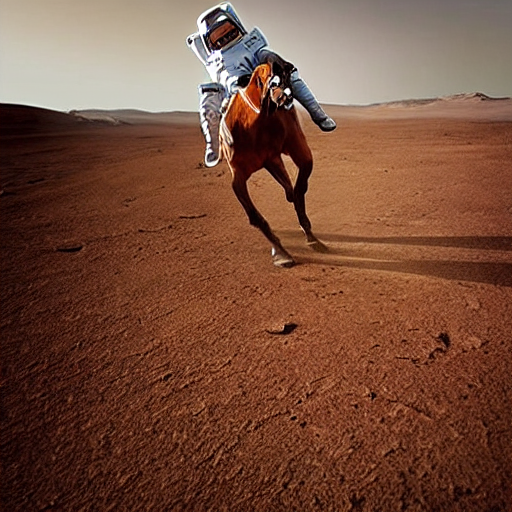

In [15]:
ret_old["image"][0]

## Use the new prompt, without prompt to prompt

In [16]:
new_prompt = " ".join([piece.new for piece in prompt])

naive_new_emb = get_text_embedding(new_prompt, pipe.tokenizer, pipe.text_encoder)
naive_new_emb = torch.cat([uncond_embeddings, naive_new_emb], dim=0)
print(naive_new_emb.shape)
ret_naive_new = pipe2(prompt="", text_embeddings=naive_new_emb, latents=latents.clone())

torch.Size([2, 77, 768])


  0%|          | 0/51 [00:00<?, ?it/s]

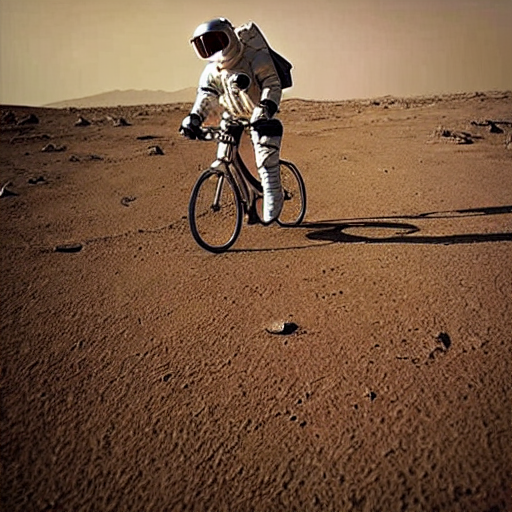

In [17]:
ret_naive_new["image"][0]

## Use the new prompt with prompt to prompt

In [18]:
ret = pipe2(prompt="", text_embeddings=(keys, values), latents=latents.clone())

  0%|          | 0/51 [00:00<?, ?it/s]

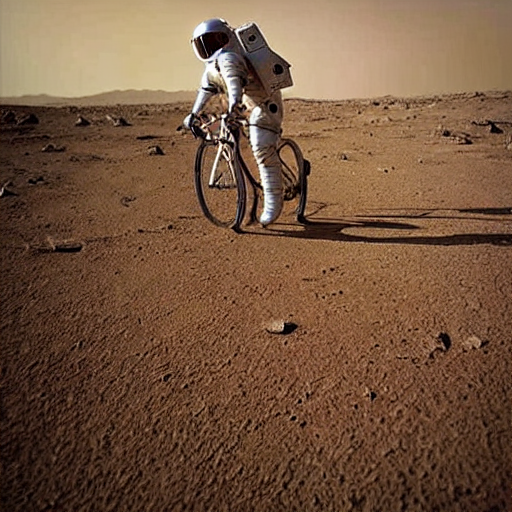

In [19]:
ret["image"][0]

## use the old prompt in the first 10 steps (to make the output similar to the original prompt)

In [20]:
ret2 = pipe2(
    prompt="",
    use_old_emb_i=10,
    old_text_embeddings=old_emb,
    new_text_embeddings=(keys, values),
    latents=latents.clone(),
)

  0%|          | 0/51 [00:00<?, ?it/s]

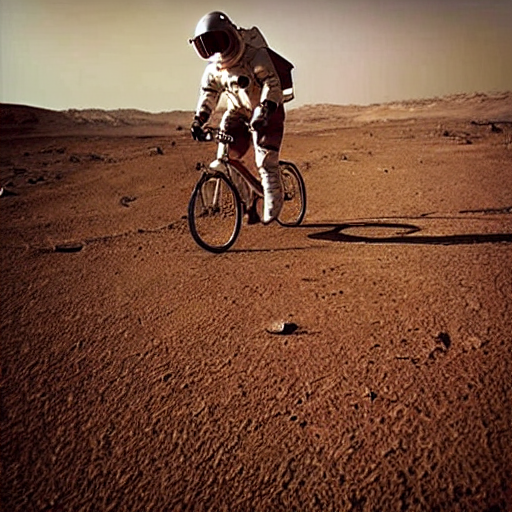

In [21]:
ret2["image"][0]